In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6
rcParams.update({'font.size': 15})

from nideep.eval.learning_curve import LearningCurve
from nideep.eval.eval_utils import Phase

import nideep.eval.log_utils as lu
    # set up Python environment: numpy for numerical routines, and matplotlib for plotting
import h5py
import caffe

print("Done importing")

Done importing


## Plot learning curve

* learning-curve from log-files

In [3]:
# if there are multiple gpu devices, choose the first one 
caffe.set_device(0)
caffe.set_mode_gpu()
model_root = '/mnt/raid/dnn/cindy/modelfiles/'
work_root = '/mnt/antares_raid/home/cindy/'
model_def = work_root+'adhara/experiments/10/train_val_acc.prototxt'
model_weights = model_root+'10/te_iter_100000.caffemodel'
# model_def = '/mnt/raid/dnn/jm/dnn_clean/models_grouptalk_1/train_val_acc_1.prototxt'
# model_weights = '/mnt/raid/dnn/jm/dnn_clean/models_grouptalk_1/gt_1_iter_5000.caffemodel'
## check where lies the modelfile according to experiment-record file
# load train_val prototxt
net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)label01

/usr/lib/pymodules/python2.7/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


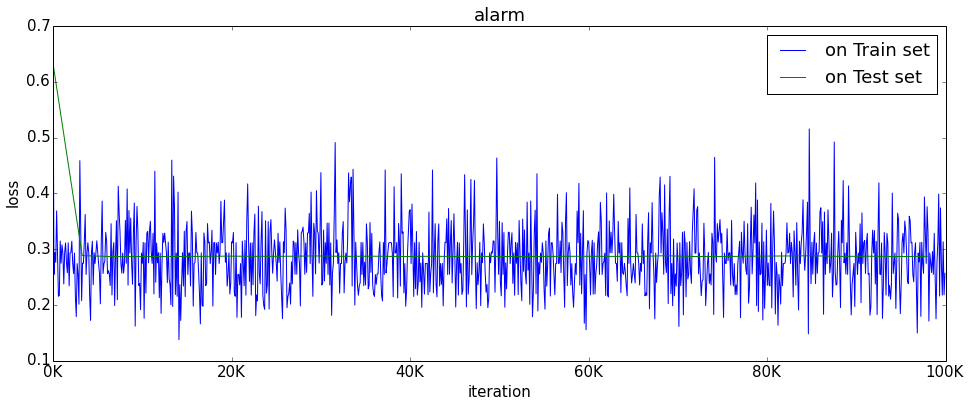

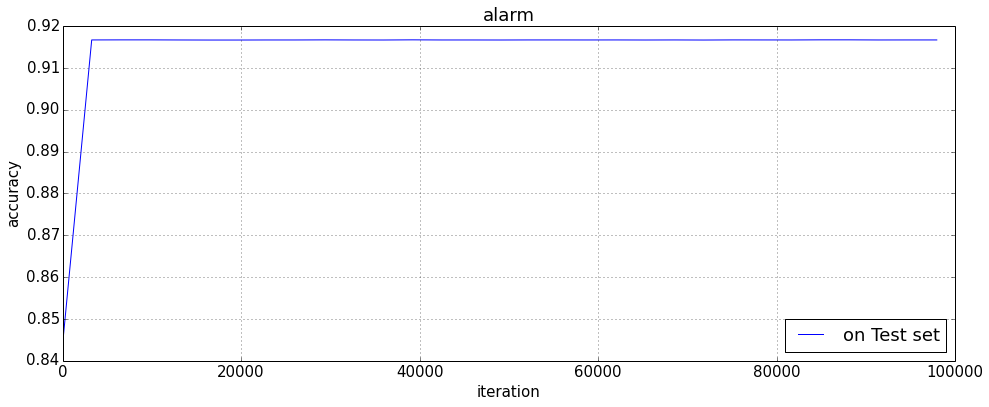

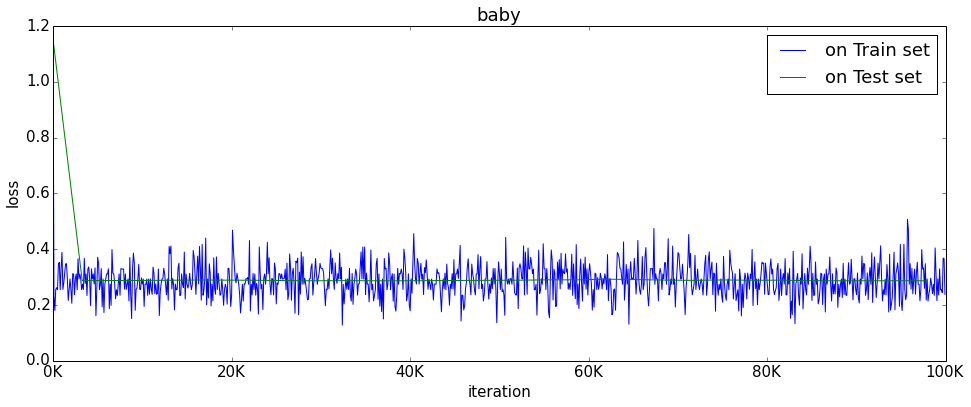

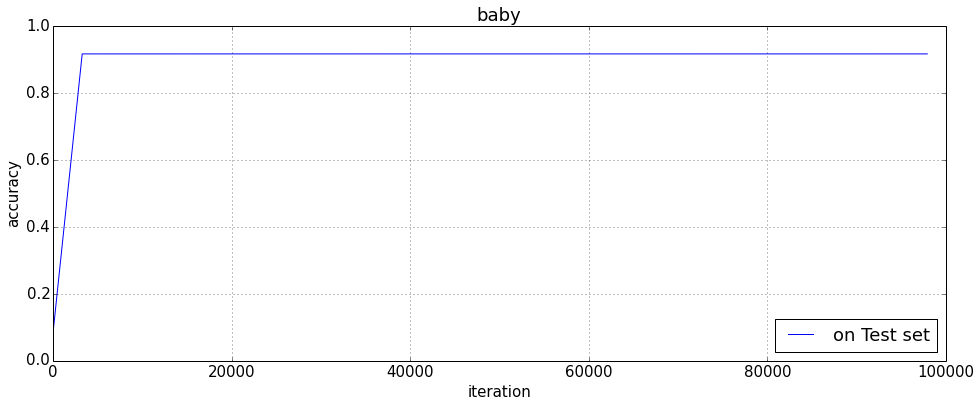

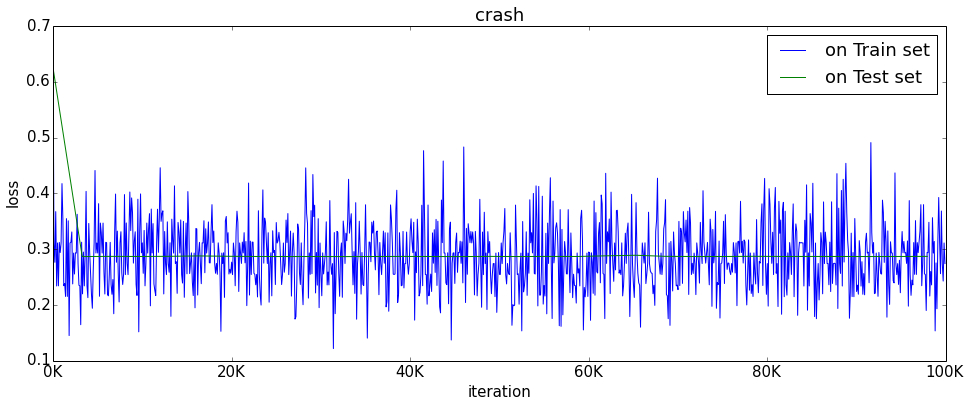

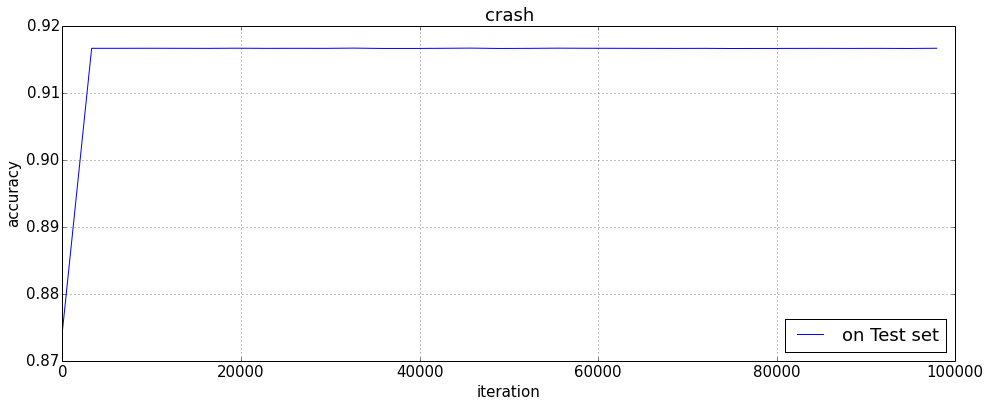

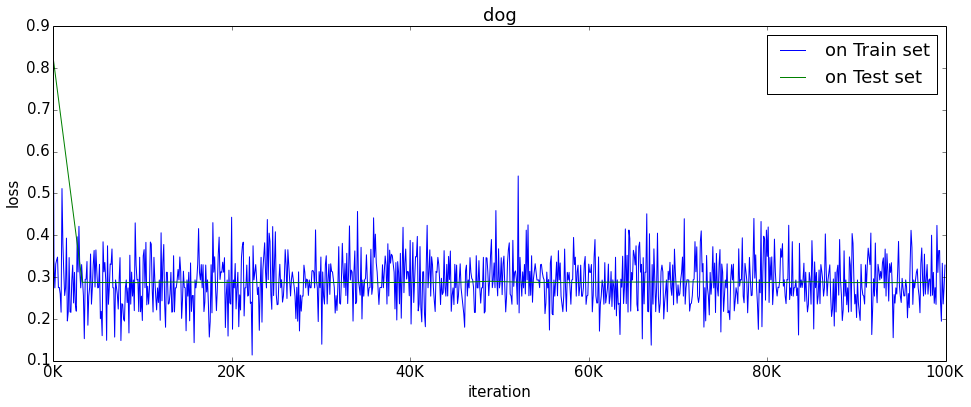

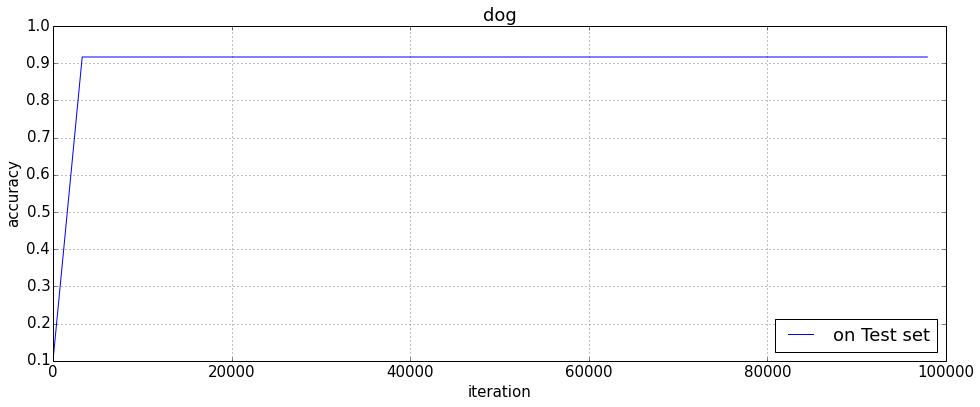

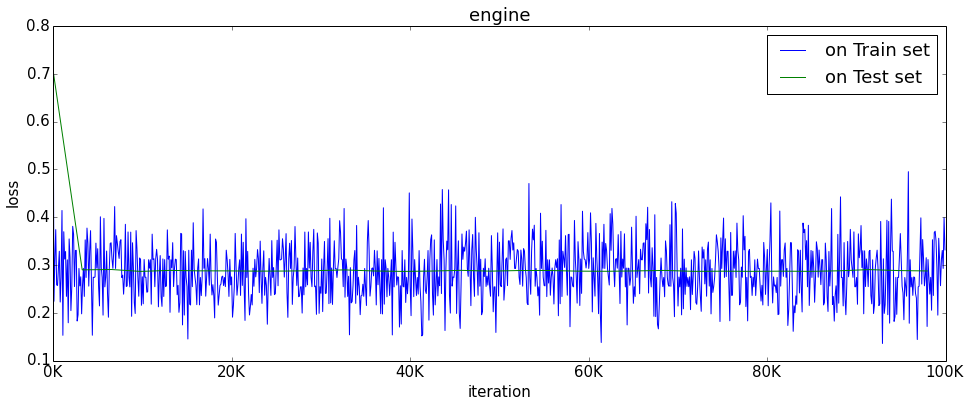

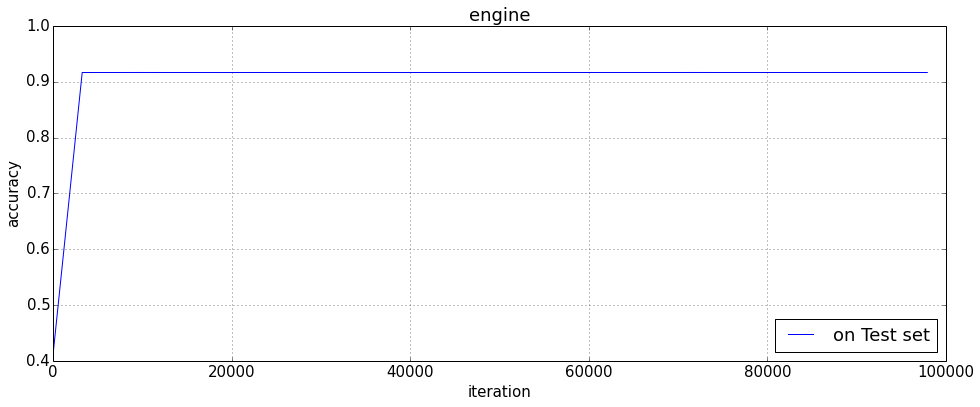

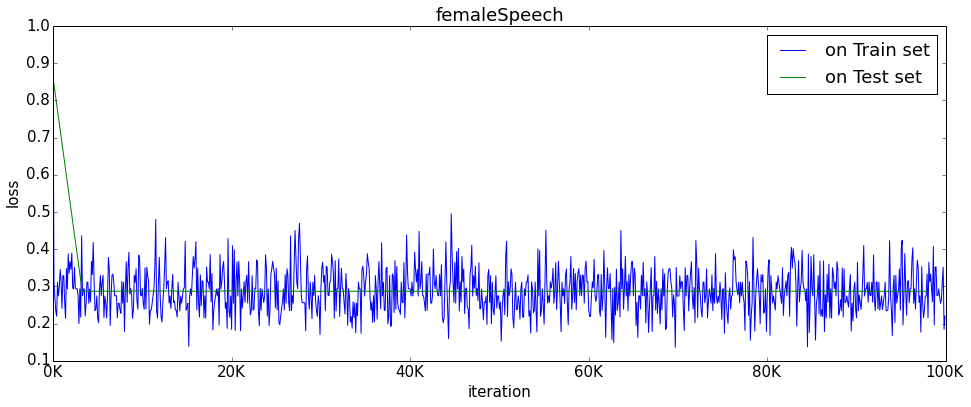

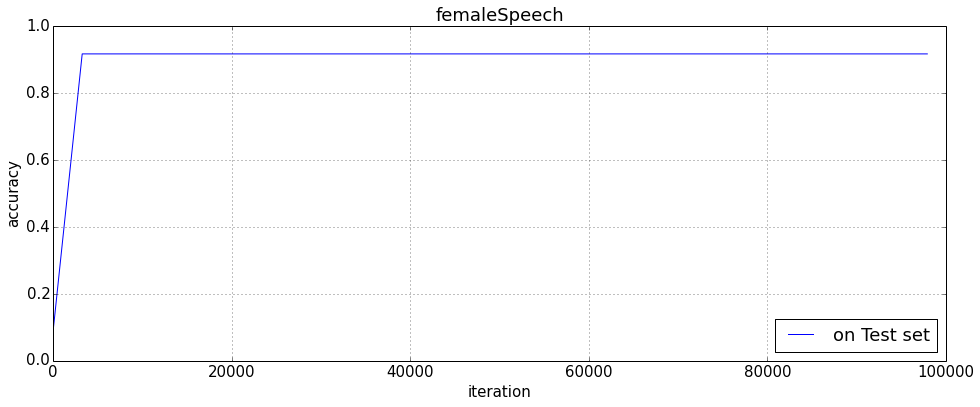

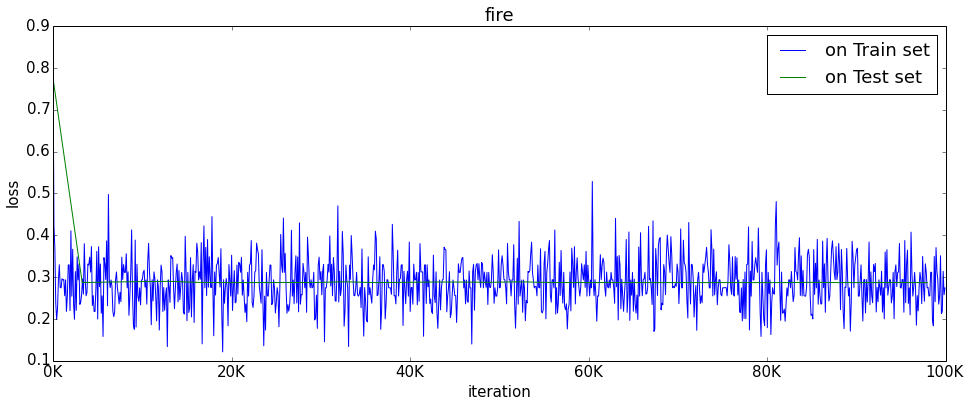

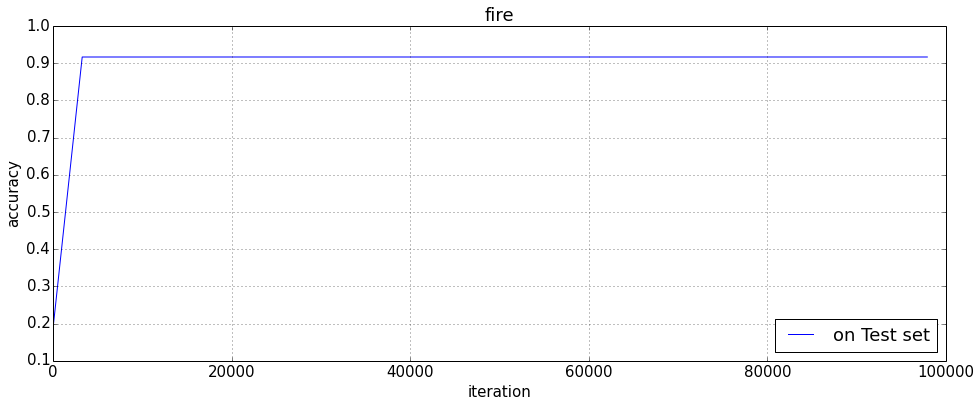

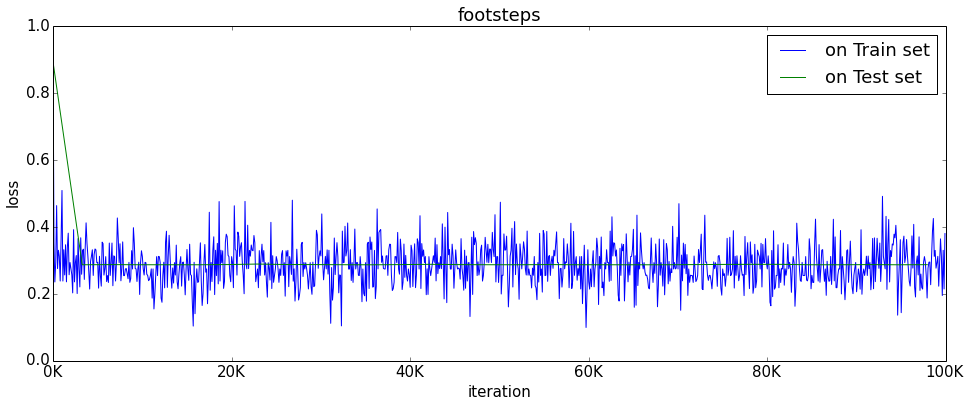

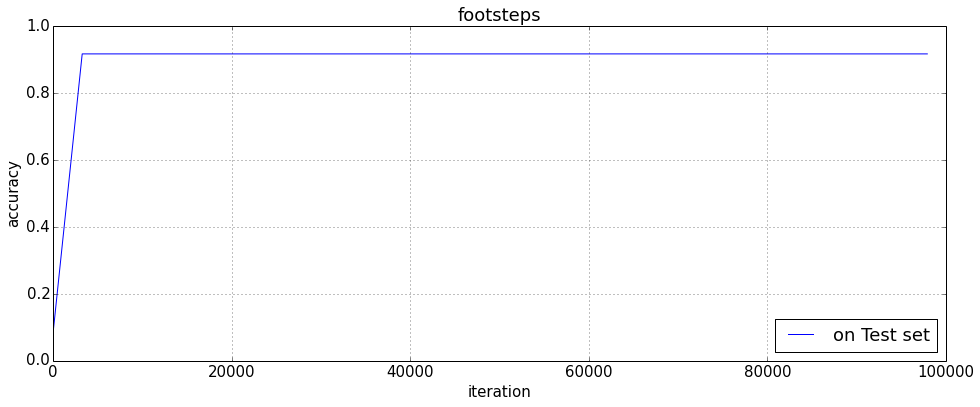

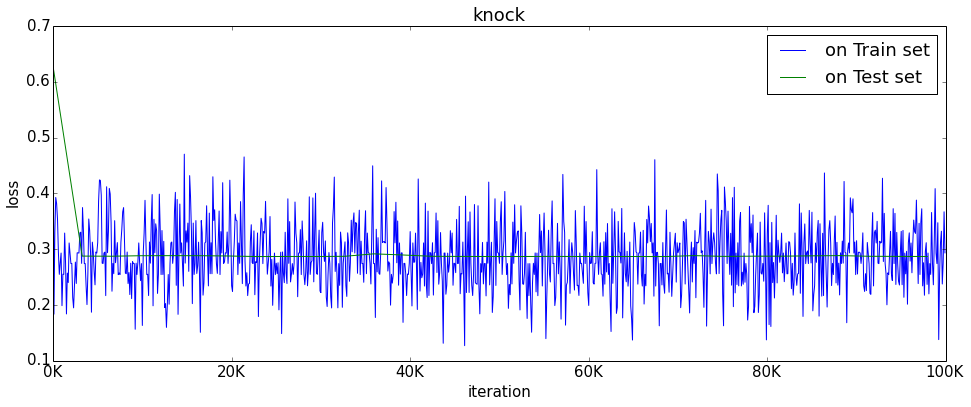

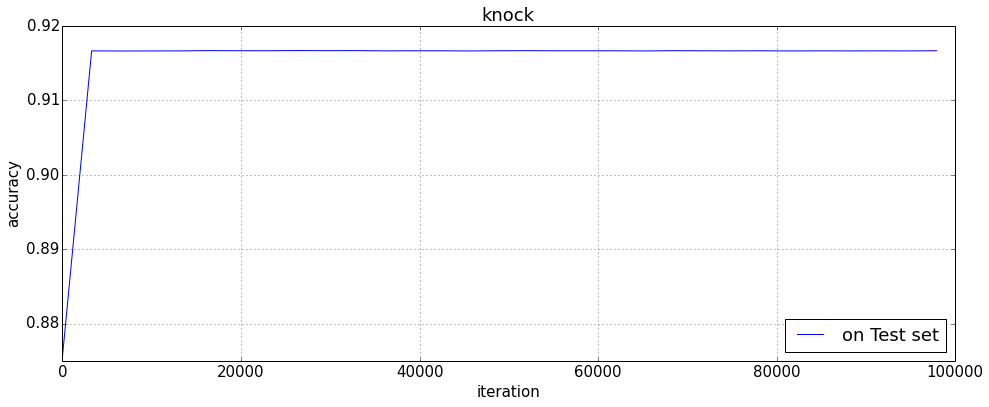

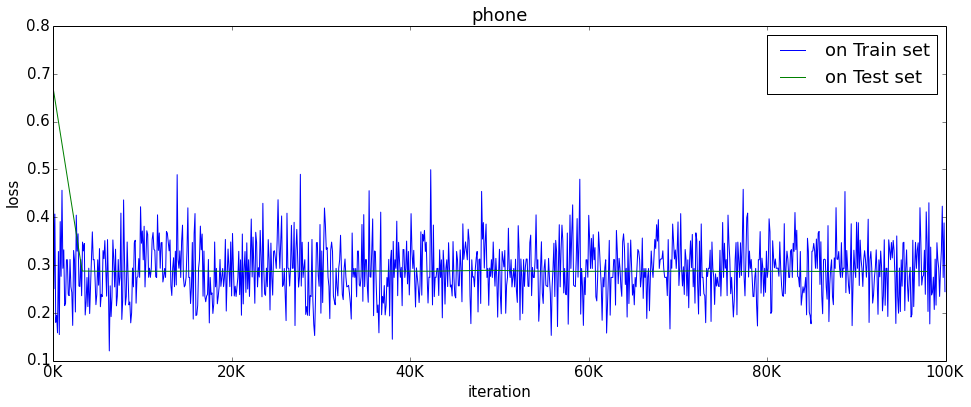

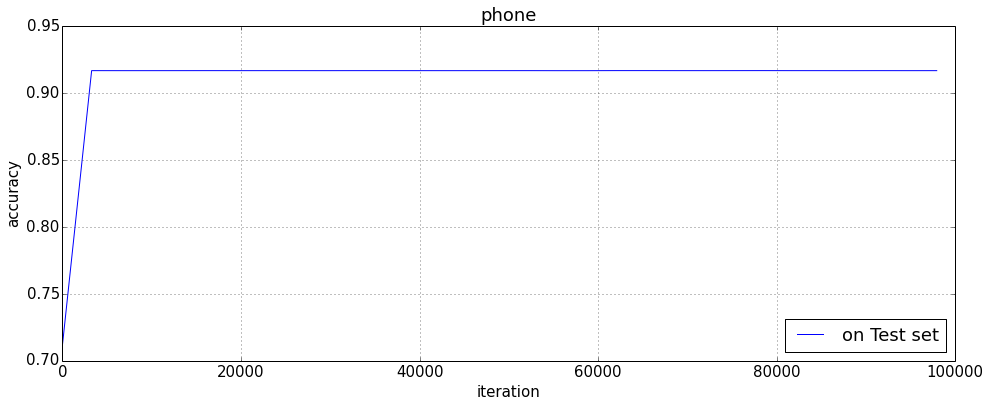

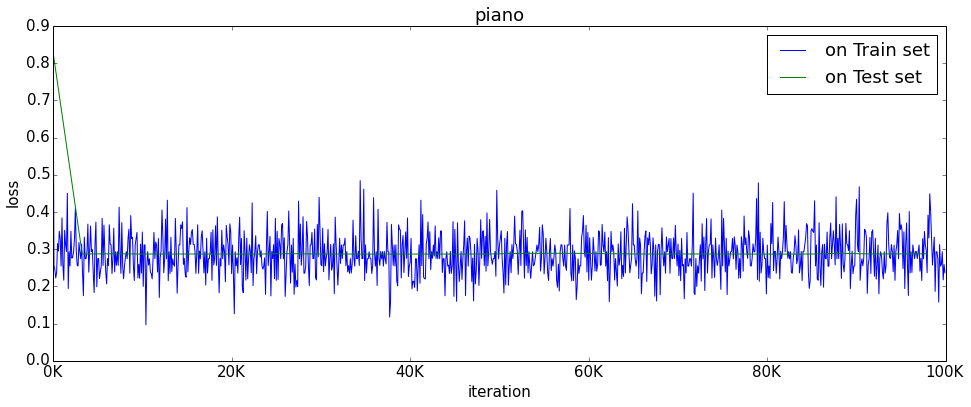

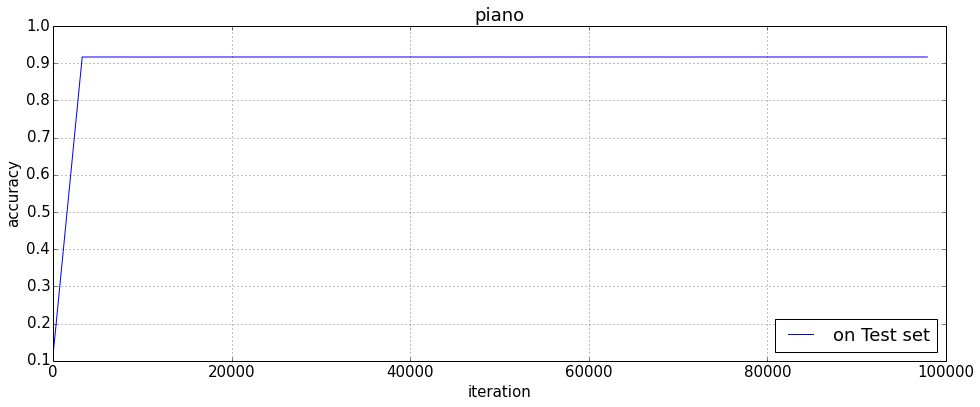

In [3]:
root_path = '/mnt/antares_raid/home/cindy/sabik/experiments/14/'
# root_path = '/mnt/antares_raid/home/cindy/adhara/experiments/13/'
# root_path = '/mnt/antares_raid/home/cindy/merope/experiments/11/'
log_path = root_path+'caffe.INFO'

e = LearningCurve(log_path)
e.parse()

soundtypes=['alarm', 'baby', 'crash', 'dog', 'engine', 'femaleSpeech', 'fire',
       'footsteps', 'knock', 'phone', 'piano']

K = len(soundtypes)  #get number of class labels
# calculate average accuracy and loss
total_loss_test = e.list('loss01', Phase.TEST)
total_loss_train = e.list('loss01',Phase.TRAIN)
##TODO: currently just use the test accuracy
total_accuracy_test = e.list('acc01',Phase.TEST)
# total_accuracy_train = e.list('acc01',Phase.TRAIN)
for s in range(K):
    plt.figure()
    for phase in [Phase.TRAIN, Phase.TEST]:    
        num_iter = e.list('NumIters', phase)
        loss = e.list('loss'+str(s+1).zfill(2), phase)
        if s!=0:
            if phase==Phase.TRAIN:
                total_loss_train += loss
            else:
                total_loss_test += loss
 
        plt.plot(num_iter, loss, label='on %s set' % (phase,))
        plt.xlabel('iteration')
        # format x-axis ticks
        ticks, _ = plt.xticks()
    
        plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])
        plt.ylabel('loss')
        #plt.title(e.name())
        plt.title(soundtypes[s])
        plt.legend()
        plt.savefig(root_path+'plots/loss'+str(s+1).zfill(2)+soundtypes[s]+'.png')
    plt.figure()
    num_iter = e.list('NumIters', Phase.TEST)
    acc = e.list('acc'+str(s+1).zfill(2), phase)
    if s!=0:
        if phase==Phase.TEST:
            total_accuracy_test += acc
    plt.plot(num_iter, acc, label='on %s set' % (phase,))

    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.title(soundtypes[s])
  
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig(root_path+'plots/accuracy'+str(s+1).zfill(2)+soundtypes[s]+'.png')


* learning-curve from snapshots

In [2]:
def __getSensSpecLists(modelfilename,netFile,testdataFile):
    # if there are multiple gpu devices, choose the first one 
    caffe.set_device(0)
    caffe.set_mode_gpu()
    ## check where lies the modelfile according to experiment-record file
    # load train_val prototxt
    net = caffe.Net(netFile,      # defines the structure of the model
                    modelfilename,  # contains the trained weights
                    caffe.TEST)     # use test mode (e.g., don't perform dropout)label01
    test_data_list = np.loadtxt(testdataFile,dtype='string')
    set_size = 0
    for i in range(test_data_list.shape[0]):
        temp_file = test_data_list[i] 
        temp_data =h5py.File(temp_file,'r')
        set_size+=temp_data['ratemap'].shape[0]
    test_iter = np.ceil(set_size*1.0/128).astype(int)
    ### There are 11 classes
    N = 11
    predict_name_list = []
    label_name_list = []
    # this list stores the number of test data_points in each class
    test_amount = [0 for i in range(N)]
    true_positive_list = [0 for i in range(N)]
    true_negative_list = [0 for i in range(N)]
    for i in range(N):
        predict_name_list.append('predict'+str(i+1).zfill(2))
        label_name_list.append('label'+str(i+1).zfill(2))
    for iteration in range(test_iter):
        output = net.forward(blobs=predict_name_list)
        for k in range(N):
            temp_output = output[predict_name_list[k]]
            true_label = net.blobs[label_name_list[k]].data[:,0,0,0].astype(bool)
            test_amount[k] += sum(true_label)
            predicted_label = (temp_output[:,0]<temp_output[:,1]).astype(bool)
            # for sensitivity
            true_positive = [x&y for (x,y) in zip(predicted_label, true_label)]
            true_positive_list[k] += sum(true_positive)
            # for specificity
            neg_label = [(not x) for x in true_label]
            neg_predicted_label = [(not x) for x in predicted_label]
            true_negative = [x&y for (x,y) in zip(neg_label, neg_predicted_label)]
            true_negative_list[k] += sum(true_negative)
    true_positive_list = np.array(true_positive_list)
    test_amount = np.array(test_amount)
    true_negative_list = np.array(true_negative_list)
    neg_test_amount = np.ones(N)*test_iter*128-test_amount
    # print neg_test_amount
    sensitivity_list = np.divide(true_positive_list*1.0,test_amount)
    specificity_list = np.divide(true_negative_list*1.0,neg_test_amount)
    balanced_accuracy = (sensitivity_list+specificity_list)/2
    return sensitivity_list,specificity_list,balanced_accuracy,

In [ ]:
model_def = '/mnt/raid/dnn/jm/dnn_clean/models_grouptalk_1/train_val_acc_1.prototxt'
model_weights = '/mnt/raid/dnn/jm/dnn_clean/models_grouptalk_1/gt_1_iter_5000.caffemodel'
testdataFile = '/home/jm/data/twoears/clean2/split/twoears_data_test.txt'
sensitivity_list,specificity_list,balanced_accuracy = __getSensSpecLists(model_def,model_weights,testdataFile)